In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner 
# import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
from math import sqrt

from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 
from scipy.stats import pearsonr


In [2]:
file_vwnd = './vwnd.mon.mean.nc'
file_uwnd = './uwnd.mon.mean.nc'
dataset_vwnd = nc.Dataset(file_vwnd)
dataset_uwnd = nc.Dataset(file_uwnd)

vlon, vlat = dataset_vwnd.variables['lon'], dataset_vwnd.variables['lat']
vtime = dataset_vwnd.variables['time']
vlevel =dataset_vwnd.variables['level']
vwnd = dataset_vwnd.variables['vwnd']

ulon, ulat = dataset_uwnd.variables['lon'], dataset_vwnd.variables['lat']
utime = dataset_uwnd.variables['time']
ulevel =dataset_uwnd.variables['level']
uwnd = dataset_uwnd.variables['uwnd']


cor_num = pd.read_excel(io = r'./ACE.xlsx')
coordinate = cor_num['WP-NA'].tolist()

In [3]:
# vlevel_850 = vwnd[:1,2:3].data[0][:,:][0]
# vlevel_200 = vwnd[:1,9:10].data[0][:,:][0]

# ulevel_850 = uwnd[:1,2:3].data[0][:,:][0]
# ulevel_200 = uwnd[:1,9:10].data[0][:,:][0]
def diff_square(a, b):
    # 求两相同大小的矩阵个元素之间的平方和
    vlevel_850 = vwnd[:1,2:3].data[0][:,:][0]
    _square = np.zeros(vlevel_850.shape, dtype=float, order='C')
    for i in range(len(a)):
        for j in range(len(a[0])):
            tmp = (a[i][j] - b[i][j])**2
            _square[i][j] = tmp
    return _square

def diff_sqrt(v_200, v_850, u_200, u_850):
    # 求矩阵每个元素的二次方根
    vlevel_850 = vwnd[:1,2:3].data[0][:,:][0]
    vlevel_sqrt = np.zeros(vlevel_850.shape, dtype=float, order='C') 
    vlevel_square = diff_square(v_200, v_850)
    ulevel_square = diff_square(u_200, u_850)

    for i in range(len(vlevel_square)):
        for j in range(len(vlevel_square[i])):
            tmp = vlevel_square[i][j] + ulevel_square[i][j]
            vlevel_sqrt[i][j] = sqrt(tmp)
    return vlevel_sqrt
        
def num_month(a):
    '''
    计算循环的起始年，结束年
    '''
    if a == 1982:
        num_months = (1982 - 1948 + 1) * 12 
        num_month_1997to1982 = (1998 - 1982) * 12 #计算1982年1月到1997年12月的192月数
        start = num_months
        end = start + num_month_1997to1982
    elif a == 1998:
        start = (1998 - 1948 + 1) * 12 + 1
        num_month_2021to1998 = (2022 - 1998) * 12 #计算1998年1月到2021年12月的288月数
        end = start + num_month_2021to1998
    else:
        print("Input must be 1982 or 1998!")
    return start, end

# 循环时间
def sum_year(start, end, vwnd, uwnd):
    '''
    计算平均值
    '''
    sum_months = np.zeros(vwnd[:1,0:1].data[0][:,:].shape, dtype=float, order='C')
    for i in range(start, end): 
        tmp_vlevel_850 = vwnd[i:i+1,2:3].data[0][:,:][0]
        tmp_vlevel_200 = vwnd[i:i+1,9:10].data[0][:,:][0]
        tmp_ulevel_850 = uwnd[i:i+1,2:3].data[0][:,:][0]
        tmp_ulevel_200 = uwnd[i:i+1,9:10].data[0][:,:][0]

        tmp_vwp = diff_sqrt(tmp_vlevel_200, tmp_vlevel_850, tmp_ulevel_200, tmp_ulevel_850)

        sum_months += tmp_vwp
#     diff_mean = sum_months / num_months
    return sum_months

start_82, end_82 = num_month(1982)
start_98, end_98 = num_month(1998)

print(start_82, end_82, start_98, end_98)

420 612 613 901


In [22]:
vws = sum_year(420, end_98, vwnd, uwnd)


In [25]:
vws.shape

(1, 73, 144)

In [4]:
ls_mean_year = []
count = 0
for i in range(420, 420 + 40 * 12, 12): 
    sum_month_year =  np.zeros(vwnd[:1,3:4].data[0][:,:].shape, dtype=float, order='C')
    
    tmp_vws = sum_year(i, i+12, vwnd, uwnd)
    sum_month_year += tmp_vws
    mean_year = sum_month_year / 12
#     mean_year = mean_year.tolist()
    ls_mean_year.append(mean_year[0])
    count += 1
ls_mean_year = np.array(ls_mean_year)
reshape_mean = ls_mean_year.transpose(1,2,0)

In [5]:
pearson_matrix = np.zeros((73,144), dtype=float, order='C')
p_value = np.zeros((73,144), dtype=float, order='C')
for i in range(len(reshape_mean)):
    for j in range(len(reshape_mean[i])):
        x = reshape_mean[i][j]
        y = coordinate
        tmp_correlation, _ = pearsonr(x, y)
#         print(tmp_correlation)
        pearson_matrix[i][j] = tmp_correlation
        p_value[i][j] = _
pearson_matrix = np.nan_to_num(pearson_matrix)

In [41]:
lon = vlon[:].data
lat = vlat[:].data

print(len(lon), len(lat), pearson_matrix.shape)
print(pearson_matrix.max(), pearson_matrix.min())

144 73 (73, 144)
0.6702389515636253 -0.7040250082589895


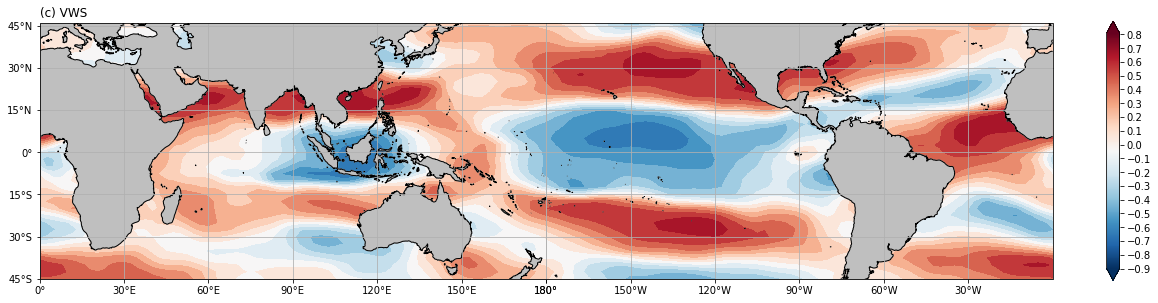

In [6]:
lon = np.append(vlon[:].data, [360.0])
# lon = vlon[:].data
lat = vlat[:].data
diff_2d = pearson_matrix
# print(diff_2d)
new_diff=[]
for i in range(diff_2d.shape[0]):
    tmp = np.append(diff_2d[i], diff_2d[i][0])
    new_diff.append(tmp.tolist())
new_diff = np.array(new_diff)
fig = plt.figure(figsize=(15,5))

proj = ccrs.PlateCarree(central_longitude=180)
# proj = ccrs.PlateCarree()
leftlon, rightlon, lowerlat, upperlat = (-180, 180.1, -45, 46)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0, 1, 1], projection = proj)

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks(np.arange(-180,180.1,30), crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())
fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(c) VWS',loc='left',fontsize =12)

cont = fig_ax1.contourf(lon, lat, new_diff, 
                 levels=np.arange(-0.9,0.81,0.1), # 颜色分片
                        zorder=0,
                transform=ccrs.PlateCarree(),
                        cmap=plt.cm.RdBu_r
#                         cmap=cmaps.BlueWhiteOrangeRed
                       )

norm = colors.Normalize(vmin=-0.9, vmax=0.81)    #确定colormap的最大最小值


fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,
                                       cmap=plt.cm.RdBu_r
                                      ),
                 orientation='vertical',
                 ticks=np.arange(-0.9,0.81,0.1).tolist(), # colorbar分片                                                 
                 extend='both',
#                  label =mul_symbol_text+'1e+06',
                fraction=0.012) 

plt.savefig("wnd_corl.png",dpi=300,bbox_inches='tight')
plt.show()

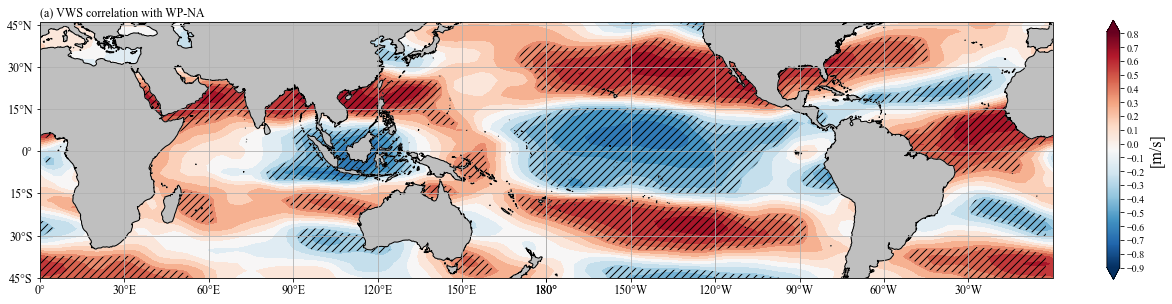

In [9]:
from matplotlib.font_manager import FontProperties

plt.rc('font',family='Times New Roman') 
# 纬度转换成太平洋为中心，增加360度一度
lon = np.append(vlon[:].data, [360.0])
# lon = vlon[:].data
# 取经度数据
lat = vlat[:].data

# new_diff = pearson_matrix
# diff_2d = pearson_matrix
# print(diff_2d)
# 对diff进行转换本初子午线为中心 为 太平洋为中心
new_diff=[]
for i in range(diff_2d.shape[0]):
    tmp = np.append(diff_2d[i], diff_2d[i][0])
    new_diff.append(tmp.tolist())
new_diff = np.array(new_diff)

fig = plt.figure(figsize=(15,5))

proj = ccrs.PlateCarree(central_longitude=180)
# proj = ccrs.PlateCarree()
leftlon, rightlon, lowerlat, upperlat = (-180, 180.1, -45, 46)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0, 1, 1], projection = proj)

fig_ax1.contourf(vlon[:].data, lat, p_value,
                 
                [np.nanmin(p_value), 0.05, np.nanmax(p_value)],
#                  [0.01, 0.05, np.nanmax(p_value)],
                hatches=['///', None], colors="none",
                transform = ccrs.PlateCarree()) # 增加斜线


fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks(np.arange(-180,180.1,30), crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())
labels = fig_ax1.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]



fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(a) VWS correlation with WP-NA',loc='left',fontsize =12)

cont = fig_ax1.contourf(lon, lat, new_diff, 
                 levels=np.arange(-0.9,0.81,0.1), # 颜色分片
                        zorder=0,
                transform=ccrs.PlateCarree(),
                        cmap=plt.cm.RdBu_r
#                         cmap=cmaps.BlueWhiteOrangeRed
                       )

norm = colors.Normalize(vmin=-0.9, vmax=0.81)    #确定colormap的最大最小值

fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,
                                       cmap=plt.cm.RdBu_r
                                      ),
                 orientation='vertical',
                 ticks=np.arange(-0.9,0.81,0.1).tolist(), # colorbar分片                                                 
                 extend='both',
#                  label =mul_symbol_text+'1e+06',
                fraction=0.012) 

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16,
        }
fc1.set_label(label="[m/s]", fontdict=font) #设置colorbar的标签字体及其大小

plt.savefig("wnd_corl.png",dpi=300,bbox_inches='tight')
plt.show()